# Worst Of Autocallable

### Importation des bibliothèques et des données

In [11]:
import numpy as np
import scipy.stats as sps
import numpy.linalg as alg
import xlrd as xl
import pandas as pd


Nous avons téléchargé les données historiques journalières pour une période de 3 ans : de 07/12/2017 jusqu'à 03/12/2020.
Vous trouvez ci-dessous les liens de téléchargement de données.

https://www.abcbourse.com/download/valeur/SX5Ep

https://www.abcbourse.com/download/valeur/PX1p

ATTENTION: Ne pas oublier de changer le chemin vers le fichier excel

In [12]:
xls = pd.ExcelFile("CAC_EURO_3ANS.xlsx")  # Load the Stocks Prices workbook
df = xls.parse("Feuil1")  # Parse the sheet into a dataframe ABCBOURSE

Nous avons calculé les log-rendements journaliers des Cac40 et Eurostoxx50 qui sont définies par $R_{t}=\log\left(\frac{P_{t}}{P_{t-1}}\right)$ afin de calculer la volatilité historique.
 


In [15]:

EuroStoxx50 = df['EuroStoxx50CLOSE'].to_numpy()  # Cast the desired column into a numpy array
CAC40= df['CAC40CLOSE'].to_numpy() 


LogREuro=np.log(EuroStoxx50[1:]/EuroStoxx50[:-1]) #Log Yields
LogRCAC=np.log(CAC40[1:]/CAC40[:-1]) 
MatrixCovLog=np.cov(LogRCAC,LogREuro) #Covariance Matrix
MatrixCov=np.cov(CAC40,EuroStoxx50)

print("Matrice Covariance Historique 3ans/jours  CAC/EuroStoxx=","\n",MatrixCovLog,"\n")
print("(%)Volatilité Historique 3ans/jours CAC40 =",np.sqrt(MatrixCovLog[0,0])*100,"\n")
print("(%)Volatilité Historique 3ans/jours Eurostoxx50=",np.sqrt(MatrixCovLog[1,1])*100,"\n")


Matrice Covariance Historique 3ans/jours  CAC/EuroStoxx= 
 [[1.90150467e-04 1.16554271e-05]
 [1.16554271e-05 1.84849795e-04]] 

(%)Volatilité Historique 3ans/jours CAC40 = 1.3789505685833752 

(%)Volatilité Historique 3ans/jours Eurostoxx50= 1.35959477475477 



### Volatilité implicite

Pour calculer la volatilité implicite, on inverse la fonction du call black & Scholes en utilisant la méthode de Newton Raphson.


$ Call~~BS:~~C(T,\sigma)=e^{-q T} S_{T} N\left(d_{1}\right)-K e^{-r T} N\left(d_{2}\right)$

$$d_{1}=\frac{\ln \frac{S_{T}}{K}+\left(r-q+\frac{\sigma^{2}}{2}\right) T}{\sigma \sqrt{T}}$$
   and
$$d_{2}=d_{1}-\sigma \sqrt{T}$$

$N.Raphson:~~\sigma_{n+1}=\sigma_{n}-\frac{C\left(T,\sigma_{n}\right)}{Vega\left(T,\sigma_{n}\right)}$

$~~$

In [16]:
#Pricer BS Pour Vol Implicite

def Price(r,T,So,sigma,K,q,type="C"):
    d1 = (np.log(So / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(So / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    C=np.exp(-q*T)*So*sps.norm.cdf(d1)-K*np.exp(-r*T)*sps.norm.cdf(d2)
    P=-np.exp(-q*T)*So*sps.norm.cdf(-d1)+K*np.exp(-r*T)*sps.norm.cdf(-d2)
    if (type!="C"):
        return(P)
    else: 
        return(C)

Price(0.00979/4,0.25,65.38,0.215,65,0.05,"P") #test

#volatitlité implicite par Newton Raphson

def newton_volImpl_call(So, K, T, C, r, sigma,q):
    d1 = (np.log(So / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(So / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = So * sps.norm.cdf(d1) - K * np.exp(-r * T) * sps.norm.cdf(d2) - C
    
    vega = (1 / np.sqrt(2 * np.pi)) * So *np.exp(-q * T)* np.sqrt(T) * np.exp(-(sps.norm.cdf(d1) ** 2) * 0.5)
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while abs(xnew - xold) > tolerance:
    
        xold = xnew
        xnew = (xnew - fx - C) / vega
        
        return abs(xnew)

Pour le calcul nous avons utilisé $:$

   Un taux $r=0.11 \% $
   
   Deux calls de maturités 3ans pour Cac40 et Eurostoxx : $C1=367.57$ et $C2=304.8$, ces valeurs sont extraites du site BourseDirect.fr et Eurex.com
   
   Deux strikes $K1=5600$ et $K2=3500$, comme dans le cours de Mr khalifie on calcul la volatilité implicite at the money (ATM) ainsi nous avons choisi les strike les plus proches de spots.
   
   Une sigma $\sigma$ historique de 3 ans 
   

In [17]:
   
#Calcul de la volatilité implicite 

N=20 #=precision 10**-6 pour Bissection

rf=0.0011 #france 20Y 20/12/2020
C1=367.57 #CAll CAC40 3An  BourseDirect.fr  367.57 3an
K1=5600 #Strike 5600 le plus proche trouvé sur Spot 07/12/20 5569.82
S1o=CAC40[0]

print("Volatilité implicite 3ANS CAC40 Par Newton-Raphson=",newton_volImpl_call(S1o, K1, 3, C1, rf*3,np.sqrt(MatrixCovLog[0,0])*np.sqrt(3*252),0),"\n")

C2= 304.8 #CALL EuroStoxx50 eurex.com/ 3530.08 Spot 08/12/20  304.8 3ans
K2=3500 #Strike le plus proche trouvé 
S2o=EuroStoxx50[0]
 
print("Volatilité implicite 3ANS EuroStoxx50 Par Newton-Raphson=",newton_volImpl_call(S2o, K2, 3, C2, rf*3,np.sqrt(MatrixCovLog[1,1])*np.sqrt(3*252),0),"\n")

sigma1=newton_volImpl_call(S1o, K1, 3, C1, rf*3, np.sqrt(MatrixCovLog[0,0])*np.sqrt(3*252),0) #VOL 3ANS/jours
sigma2=newton_volImpl_call(S2o, K2, 3, C2, rf*3, np.sqrt(MatrixCovLog[1,1])*np.sqrt(3*252),0)
sigma12=MatrixCovLog[0,1]

Volatilité implicite 3ANS CAC40 Par Newton-Raphson= 0.42998913916596165 

Volatilité implicite 3ANS EuroStoxx50 Par Newton-Raphson= 0.4725631964708538 



Nous avons ensuite construit notre propre fonction Simul_S1_S2  qui donne la simulation de Eurostoxx50 et Cac40.

In [18]:


import matplotlib.pyplot as plt

def Simul_S1_S2(n,m,T,sigmaS1,sigmaS2,sigmaS1S2,S1o,S2o,rf):

    
    S1=np.zeros((n,m+1))
    S1[:,0]=S1o

    S2=np.zeros((n,m+1))
    S2[:,0]=S2o
    dt=T/m
    
    

    DZ1 = np.sqrt(dt)*np.random.randn(n,m)
    DZ2 = np.sqrt(dt)*np.random.randn(n,m)
    DS1 = np.exp((rf-(sigmaS1**2+sigmaS1S2**2)/2)*dt + sigmaS1*DZ1+sigmaS1S2*DZ2)
    DS2 = np.exp((rf-(sigmaS2**2+sigmaS1S2**2)/2)*dt + sigmaS2*DZ2+sigmaS1S2*DZ1)
    S1=S1o*np.cumprod(DS1,axis=1)
    S2=S2o*np.cumprod(DS2,axis=1)
    
    S1oCol=np.zeros(n)+S1o
    S2oCol=np.zeros(n)+S2o
    S1=np.c_[S1oCol,S1]
    S2=np.c_[S2oCol,S2]
    return (S1,S2)





Quelques Simulations des cours journaliers CAC40 et  EuroStoxx50 sur 3ans (Cac40 en rouge et Eurostoxx50 en bleu)

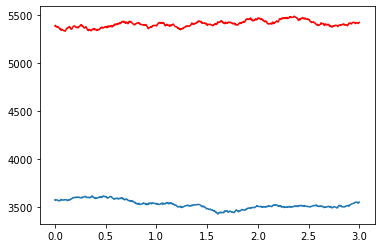

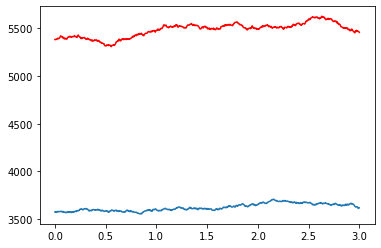

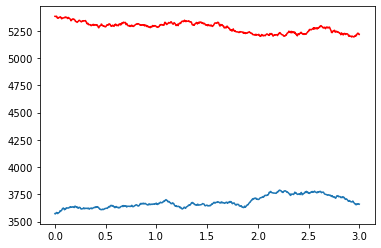

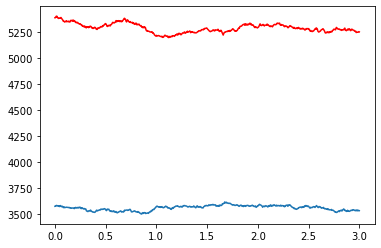

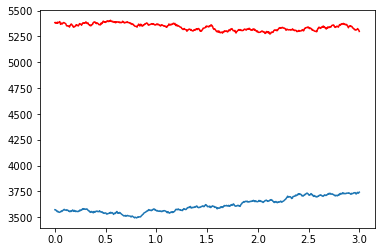

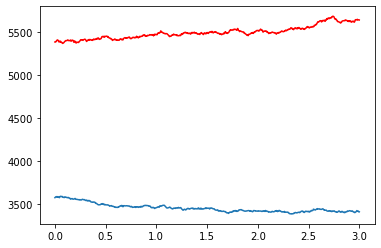

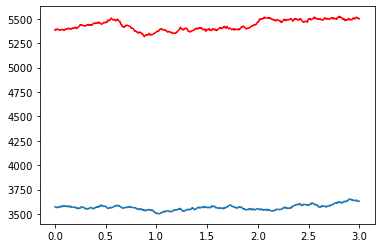

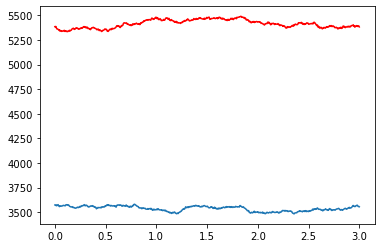

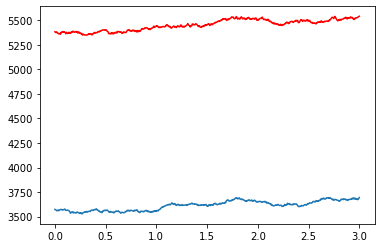

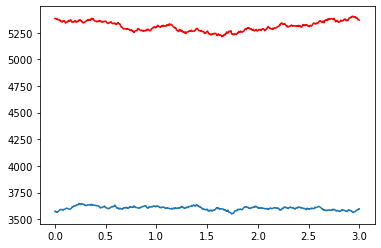

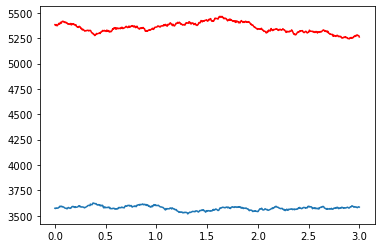

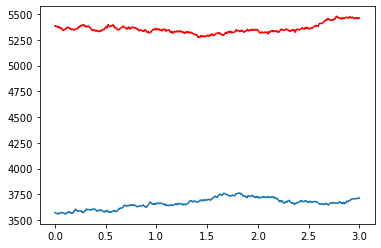

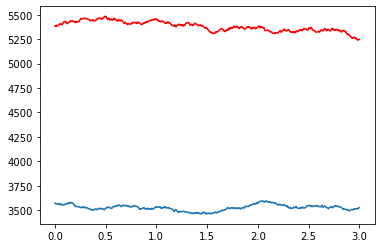

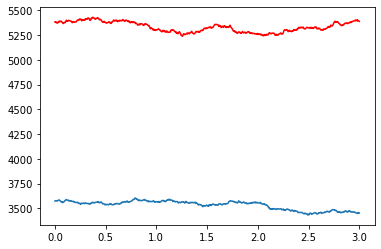

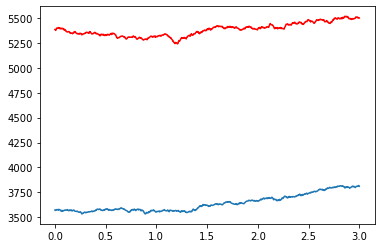

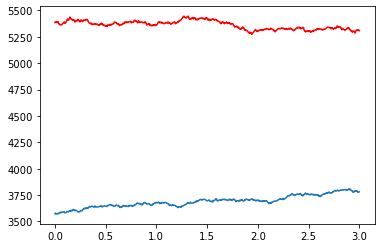

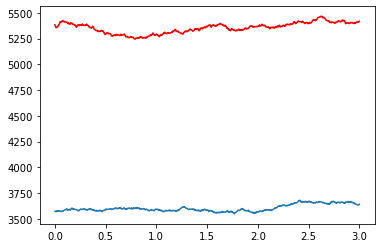

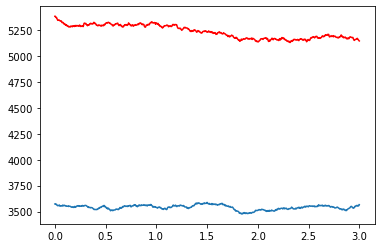

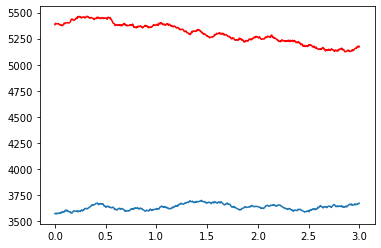

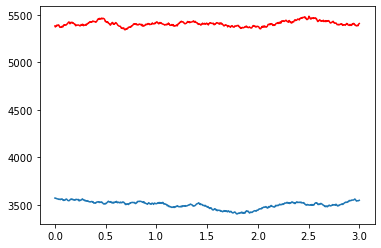

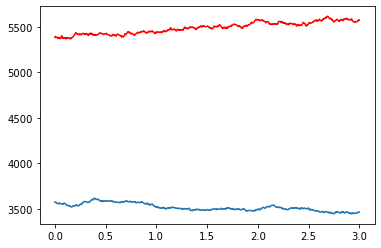

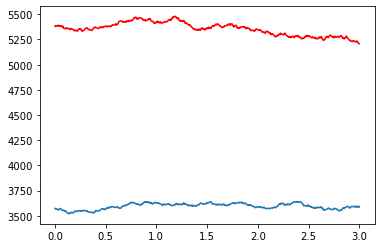

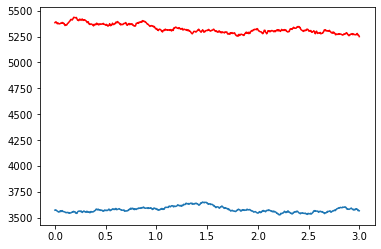

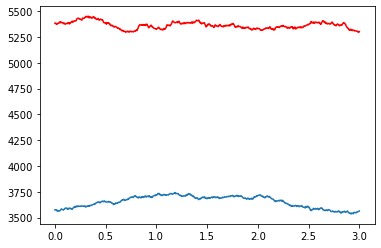

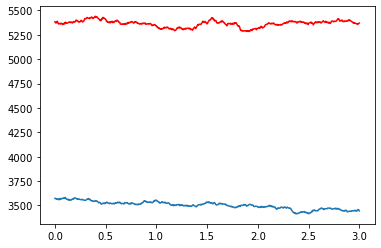

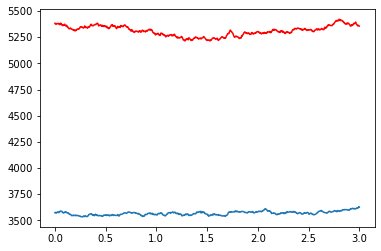

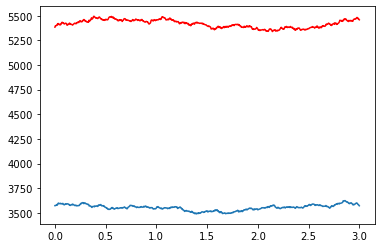

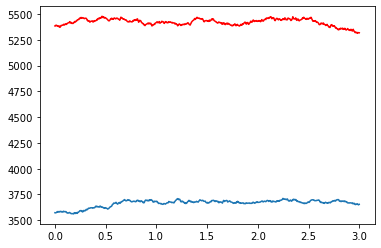

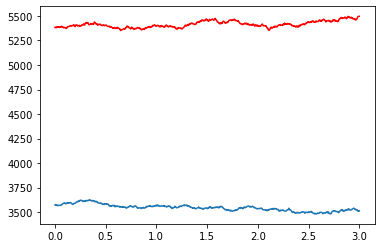

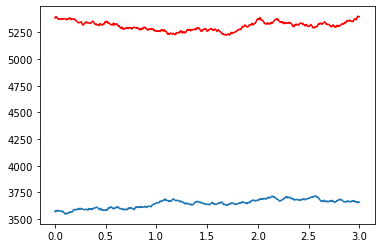

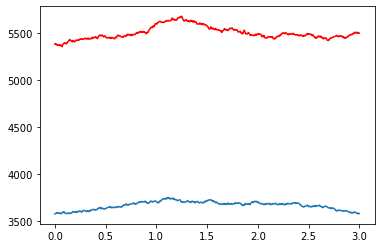

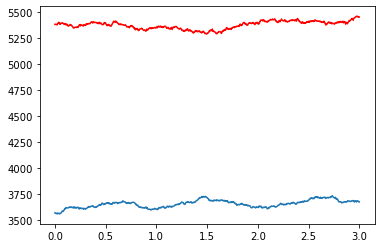

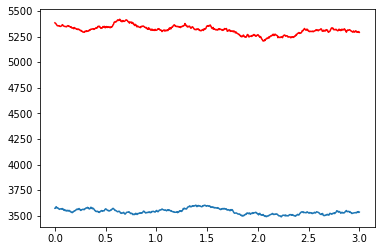

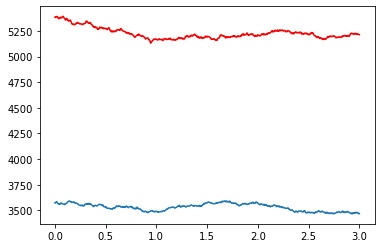

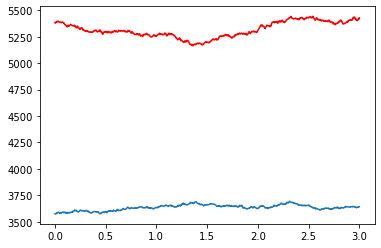

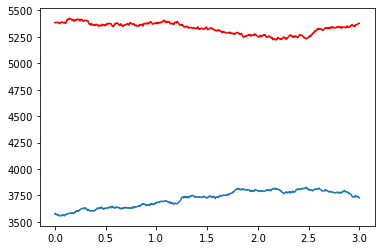

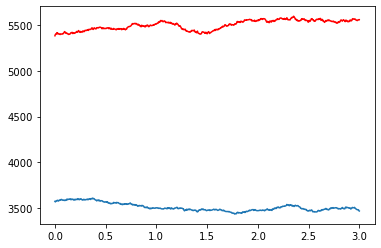

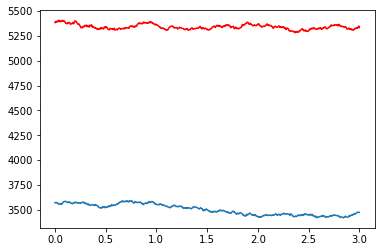

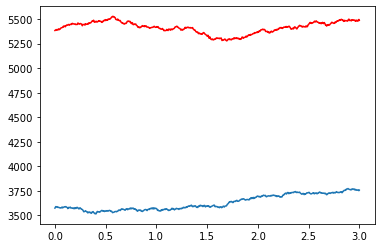

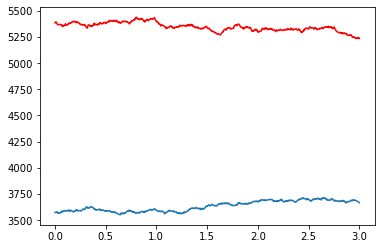

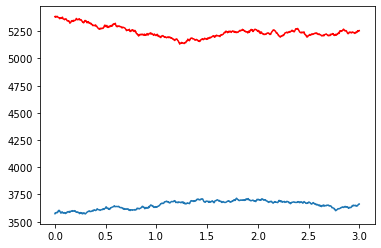

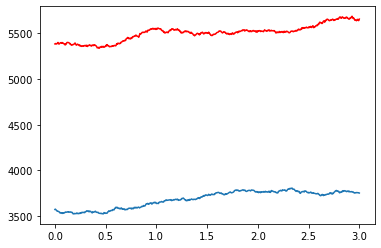

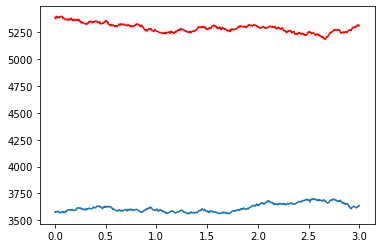

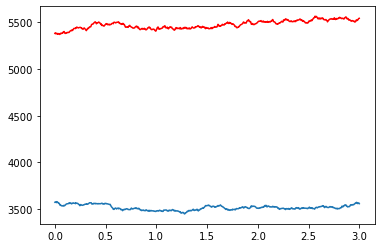

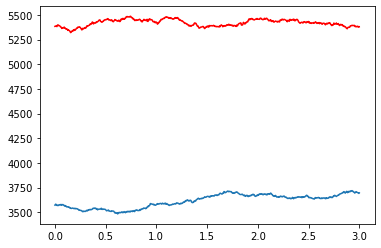

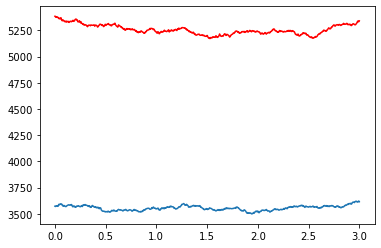

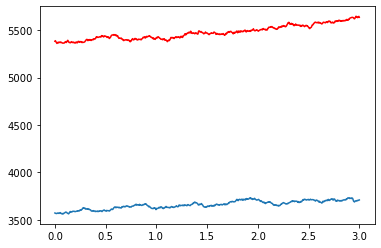

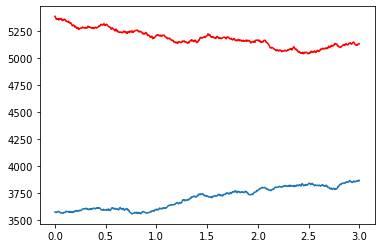

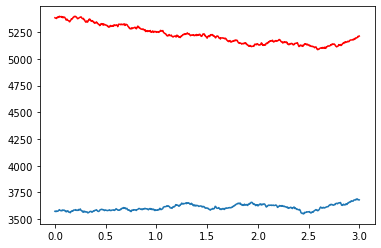

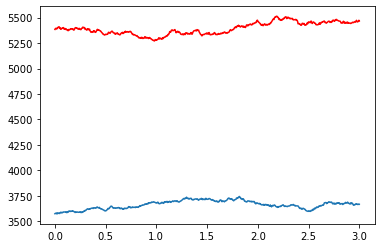

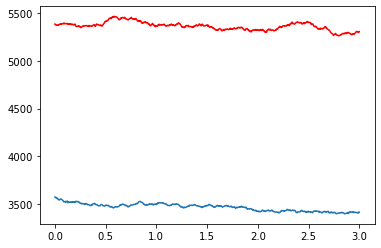

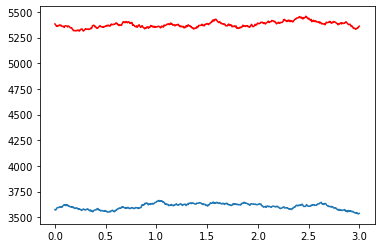

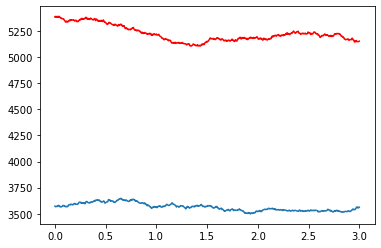

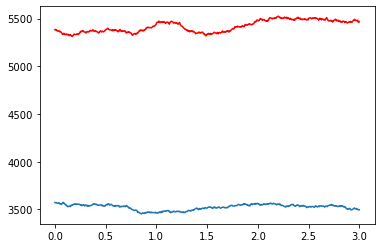

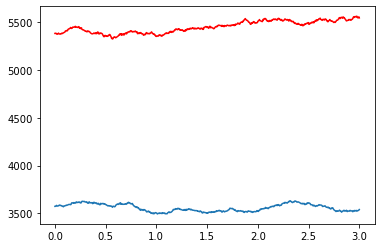

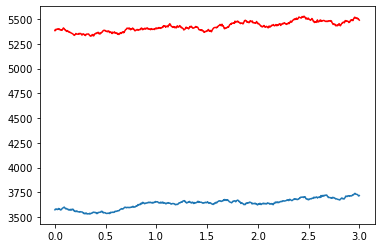

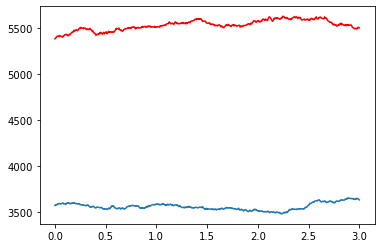

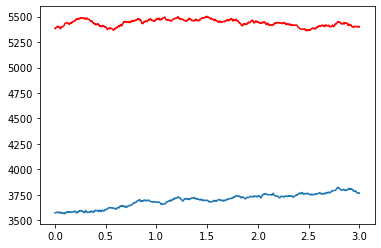

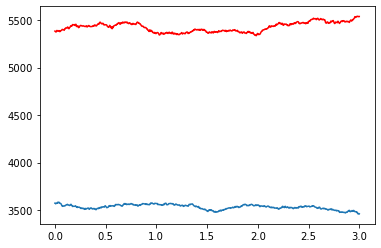

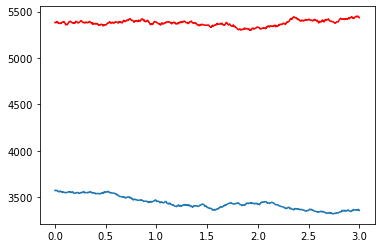

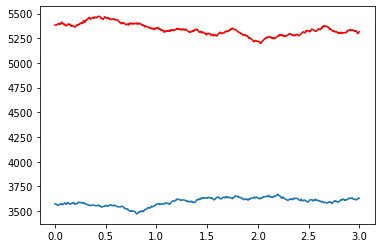

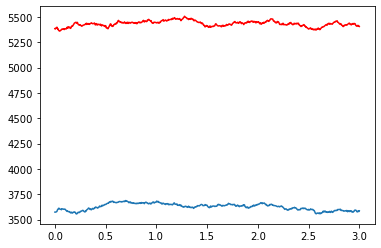

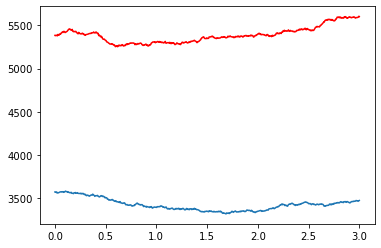

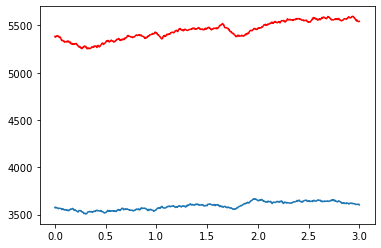

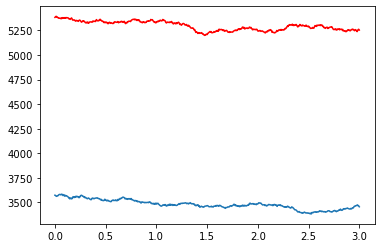

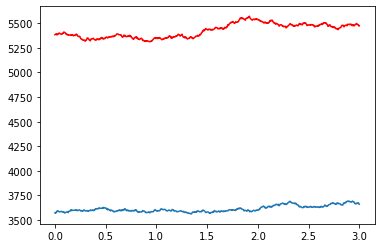

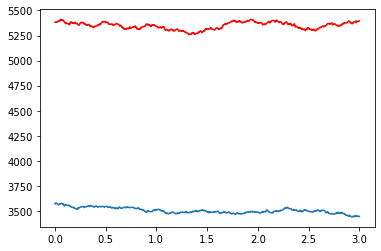

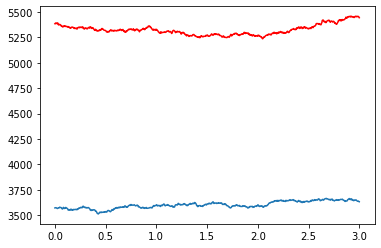

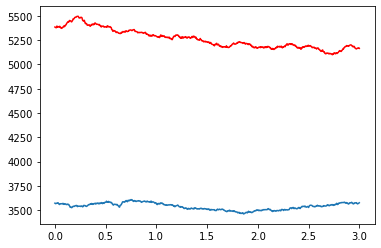

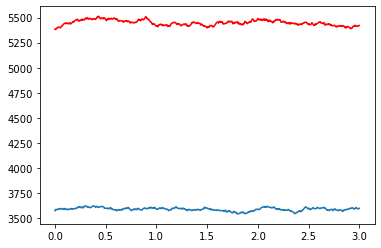

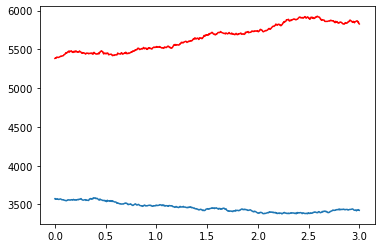

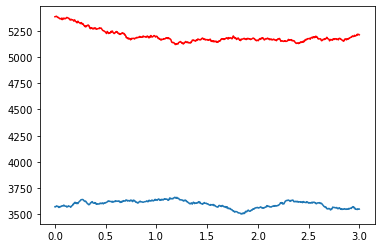

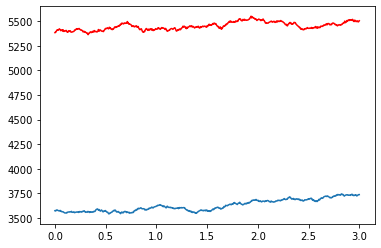

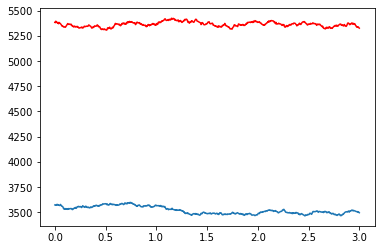

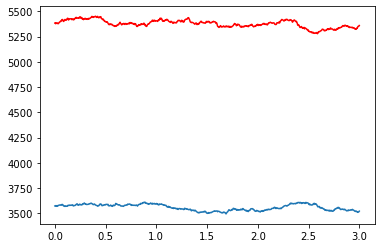

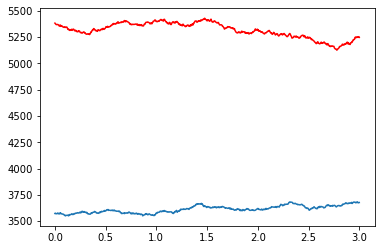

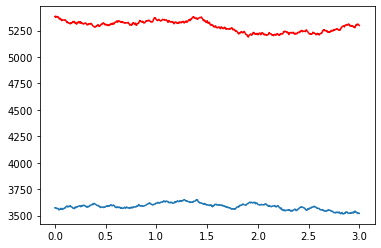

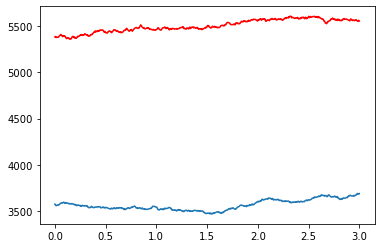

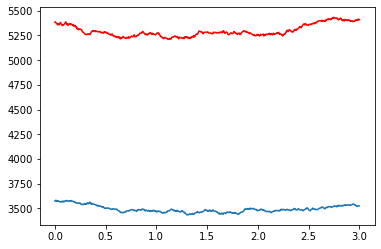

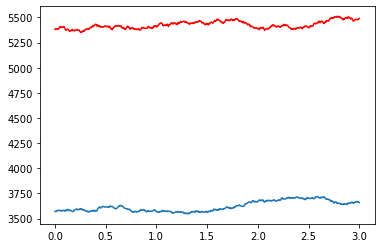

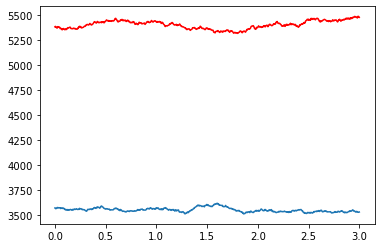

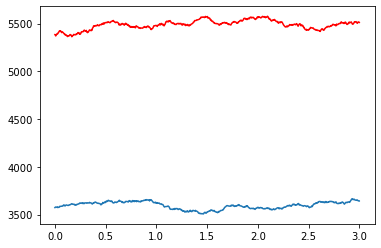

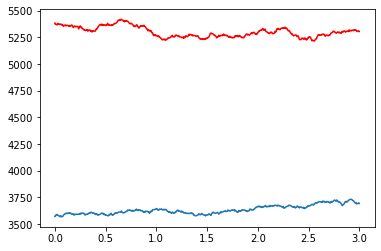

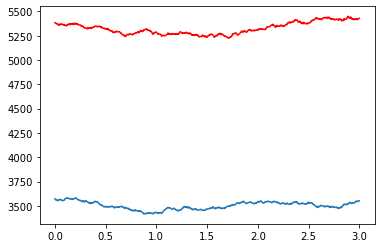

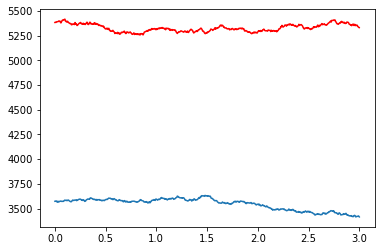

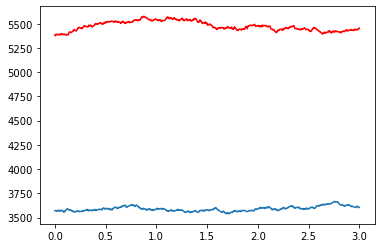

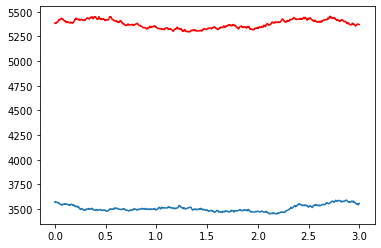

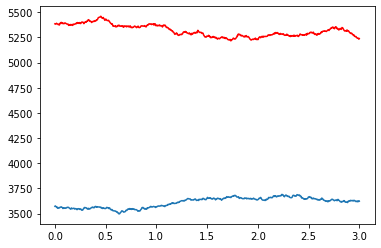

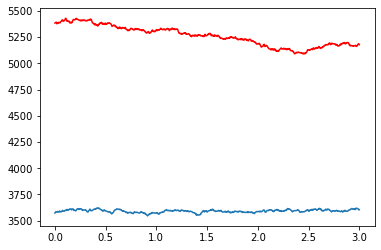

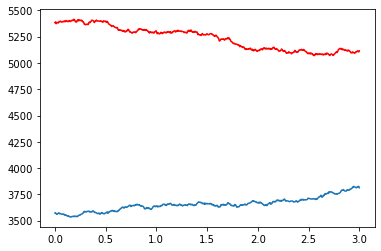

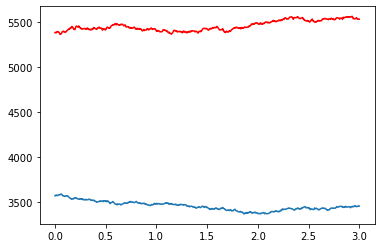

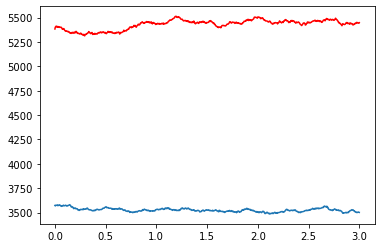

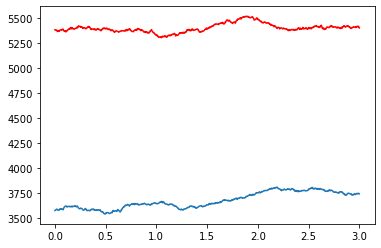

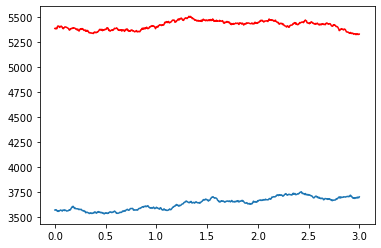

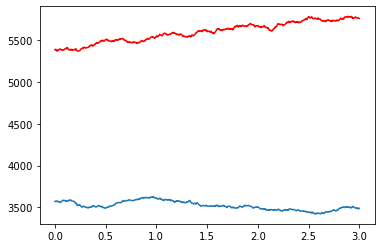

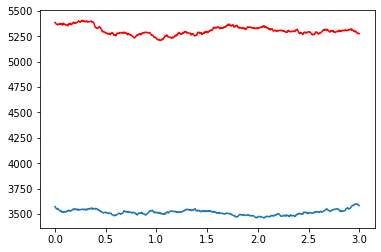

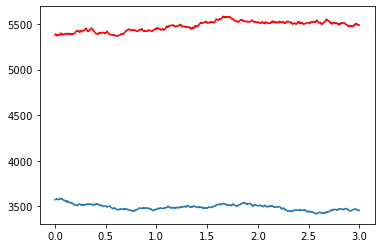

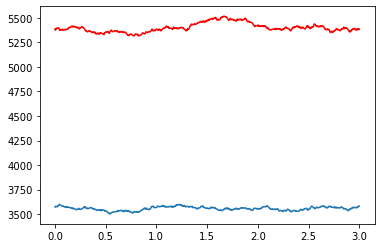

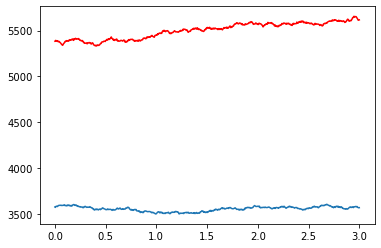

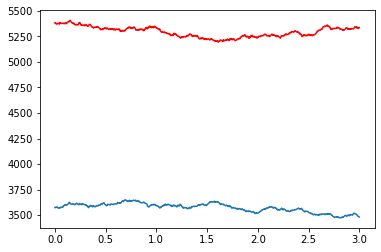

Le temps d'exécution pour n= 100 est 0.09574341773986816 



In [19]:
from time import time
t1=time()
ntest=100
mtest=252*3
Ttest=3
tntest=np.arange(0,Ttest+Ttest/(mtest),Ttest/(mtest))
S1test,S2test=Simul_S1_S2(ntest,mtest,Ttest,sigma1/np.sqrt(252*3),sigma2/np.sqrt(252*3),sigma12,S1o,S2o,rf)
#nous avons divisé les sigma par racine de 252*3 pour obtenir des volatilités journalières
t2=time()
for i in range(ntest): 
    plt.figure("")  # début de la figure 
    plt.plot(tntest,S1test[i,:],label="explicit",color="Red")
    plt.plot(tntest,S2test[i,:],label="explicit")
    plt.show() 
print("Le temps d'exécution pour n=",ntest,"est",t2-t1,"\n")


### Payoff

Nous allons Travailer dans le cas particulier d’un panier de deux actifs CAC40 et EuroStoxx50.


##### Caractéristiques

$Actif~S^{1}=Cac40$

$Actif~S^{2}=Eurostoxx50$

$Threshold~S^{1}(Tr^{1})=1.04~~(4\%)$

$Threshold~S^{2}(Tr^{2})=1.03~~(3\%)$

$Barrière~S^{1}(B^{1})=1.10~~(10\%)$

$Barrière~S^{2}(B^{2})=1.09~~(9\%)$

$Coupon~S^{1}(C^{1})=4.5\%~~semi-annuel$

$Coupon~S^{2}(C^{2})=3.5\%~~semi-annuel$

$Maturité=3~ans$

#### Description du Payoff

Les coupons potentiels étant versé de manière semi-annuelle et la maturité maximale étant de 3 ans, nous avons donc 6 dates d’observations.
Le payoff à chaque date d'observation $t_{i}~~(i=1, \ldots, m)$ est défini comme suit:

On définit la performance du CAC40 et Eurostoxx50 entre deux observation, $R_{t_{i}}^{1}~~R_{t_{i}}^{2}$

$$R_{t_{i}}^{1}={CAC_{t_{i}}} / CAC_{t_{i}-1}$$

$$R_{t_{i}}^{2}={Euro_{t_{i}}} / Euro_{t_{i}-1}$$

Où $CAC_{t_{i}}$ et $Euro_{t_{i}}$ représente la valeur des indices à la date d’observation $t_{i}$.

$~~$

On définit la performance par rapport au temps $0$, $R_{t_{i}}^{1,0}~~R_{t_{i}}^{2,0}$ 

$$R_{t_{i}}^{1,0}={CAC_{t_{i}}} / CAC_{t_{0}}$$

$$R_{t_{i}}^{2,0}={Euro_{t_{i}}} / Euro_{t_{0}}$$


$~~$

On définit la plus mauvaise performance du panier d’actifs entre deux observation, $WR_{t_{i}}:$

$$WR_{t_{i}}=\min_{k=1,2}(R^{k}_{t_{i}})$$

$~~$

Afin de pouvoir comparer l'actif qui a la moins bonne performance à la date $t_{i}$ avec son threshold respectif, on définit la variable $l_{i}:$


$$l_{i}=\arg \min_{k=1,2} (R^{k}_{t_{i}})$$

Cette variable permet de retrouve l’indice $k$ de l’actif qui a le moins bien performer à la date $t_{i}$.





$~~$

On définit la plus mauvaise performance, par rapport au temps 0, du panier d’actifs entre deux observation, $WR^{0}_{t_{i}}:$

$$WR^{0}_{t_{i}}=\min_{k=1,2} (R^{k,0}_{t_{i}})$$

$~~$

De même, pour les barrières respectives, on définit $l^{0}_{i}$:

## $$l^{0}_{i}=\arg\min_{k=1,2} (R^{k,0}_{t_{\arg\max_{j=1,...,i-1}(WR^{0}_{t_{j}})}})$$

Ainsi, cette variable permet de retrouver l’indice k correspondant à l’actif qui a la moins bonne performance (par rapport au temps 0) à la date $t_{j^{*}}$  $(<t_i)$ à laquelle la plus grande performance à été enregistré. Cela nous permettra donc vérifier que la barrière n’a pas été dépassé antérieurement. 

$~~$

On définit donc, au temps $t_{i}$, la valeur du coupon, $C_{t_{i}}$:

### $C_{t_{i}}=Not\times C^{l_{i}} \times 1_{\left\{\operatorname{WR}_{t_{i}} \geq Tr^{l_{i}}\right\}} \times 1_{\left\{\left(\max _{j=1,..,i-1}\left(\operatorname{WR^{0}}_{t_{i}}\right)\right)<B^{l^{0}_{i}}\right\}}$


Ainsi, cette expression permet le versement de coupon à deux conditions :

   $~~$1.La pire performance du panier entre les dates $t_{i}$   et $t_{i-1}$  dépasse le threshold.
	
   $~~$2.Pour $(j = 1, ... , i -1)$, à chaque date $t_{j}$   la pire performance du panier par rapport au temps $0$ n’a pas franchie la barrière. C’est-à-dire la barrière n’a pas été franchie à une date antérieure.



$~~$

Pour ce worst-of autocallable, le capital n’est pas totalement garanti. Au moment du remboursement du notional, si l'un des indices est inférieur de plus de 50% à son niveau d'ouverture, c’est-à-dire par rapport au temps $0$, le notional sera réduit de $1\%$ pour chaque $1\%$ en dessous de son niveau d'ouverture.

On définit donc, au temps $t_{i}$, la variable, $N_{t_{i}}$:

Pour $i=1,...,m-1:$


### $N_{t_{i}}=Not \times 1_{\left\{\operatorname{WR^{0}}_{t_{i}} \geq B^{l_{i}}\right\}} \times 1_{\left\{\left(\max _{j=1,..,i-1}\left(\operatorname{WR^{0}}_{t_{j}}\right)\right)<B^{l^{0}_{i}}\right\}}$
#### Et,
### $N_{t_{m}}=Not \times 1_{\left\{\left(\max _{j=1,..,i-1}\left(\operatorname{R^{0}}_{t_{j}}\right)\right)<B^{l^{0}_{m}}\right\}} \times ({\operatorname{WR^{0}}_{t_{m}}} \times 1_{\left\{\operatorname{WR^{0}}_{t_{m}} \leq 0.5\right\}}+ 1_{\left\{\operatorname{WR^{0}}_{t_{m}}>0.5\right\}})$
Ainsi, cette expression permet le remboursement anticipé du notional à la date $t_{i}$  à deux conditions :

$~~$1.La pire performance du panier par rapport au temps 0 dépasse la barrière.

$~~$2.La barrière n’a pas été franchie à une date antérieure. 

##### Si, la barrière n’a jamais été franchie, alors le notional est restitué à maturité, c’est-à-dire, à la date $t_{m}$. Cependant, le notional ne sera pas restitué entièrement si l’un des actifs se trouve en dessous de $50\%$ par rapport à son niveau initial.




$~~$

Finalement le Payoff, est la somme des différents payoffs à chaque date d’observation. 

$Payoff=\sum_{i=1}^{m} CashFlow_{i}=\sum_{i=1}^{m}\left(N_{t_{i}}+C_{t_{i}}\right)$

$Payoff_{Disc}= \sum_{i=1}^{m}e^{-rt_{i}} CashFlow_{i}~~:~~Discounted~~Payoff$

Donc le Prix est $P=\mathop{{}\mathbb{E}}(Payoff_{Disc})=\sum_{i=1}^{m} \mathop{{}\mathbb{E}}(e^{-rt_{i}}CashFlow_i)=\sum_{i=1}^{m}\mathop{{}\mathbb{E}}(e^{-rt_{i}}\times \left(N_{t_{i}}+C_{t_{i}}\right))$

Pour pricer ce produit structuré nous avons utilisé la méthode de monte classique.

On définit $P^{n}$ l'estimateur de $P$, avec $P^{n}=\frac{1}{n}\sum_{k=1}^{n} Payoff^{k}_{Disc}$

$~~$où $Payoff^{k}_{Disc}$  $~~$ $iid$ copies de $Payoff_{Disc}$


Nous avons crée notre propre outil de pricing.

#### Notre implémentation est entièrement vectorisé, nous n'avons aucune boucle qui aurait pu rallonger le temps d'exécution du programme. Ainsi, nous pouvons utiliser des samples de grandes taille pour un temps d'execution raisonnable.

### W_Auto_Bar calcule un prix pour un autocallable avec possibilité de perte de capital 

In [59]:
def W_Auto_Bar(Tr,Cap,C,n,T,m,sigma1,sigma2,sigma12,Not,S1o,S2o,rf,stat):
    CACSim,EuroSim=Simul_S1_S2(n,T*252,T,sigma1/np.sqrt(T*252),sigma2/np.sqrt(T*252),sigma12,S1o,S2o,rf)
           
    vectm=np.arange(0,T*252+252/m,252/m) ###
    vectm[1:]=vectm[1:]-1

    CAC6m=CACSim[:,vectm.astype(int)]
    Euro6m=EuroSim[:,vectm.astype(int)] 
    RCAC6m= CAC6m[:,1:]/CAC6m[:,:-1]  #Rapport ti/t(i-1) ######
    REuro6m=Euro6m[:,1:]/Euro6m[:,:-1] 
    matrixMin=np.minimum(RCAC6m,REuro6m) #Min ti/t(i-1)
    
    RCACo=CAC6m[:,1:]/S1o
    REuro0=Euro6m[:,1:]/S2o
    matrixMino=np.minimum(RCACo,REuro0) #Min ti/tO
    matrixloss=(matrixMino<=0.5)*1*(matrixMino-1)
    
    Tr=np.array(Tr)+1
    Cap=np.array(Cap)+1
    C=np.array(C)

    indMin=(RCAC6m>=REuro6m)*1 # 0 SI CAC=MIN 1 SI EURO=MIN, indice des min
    TR=Tr[indMin]
    
    indMin0=(RCACo>=REuro0)*1#
    CAPk=Cap[indMin0]#
    pr=np.cumsum((matrixMino>=CAPk)*1,axis=1)#
    Hk1=(pr==0)*1 #matrice 0 si maxmin>=Hk
                
    matrixC=C[indMin] #matrice coupon
    vectE=np.arange(0,T+1/m,1/m) 
    
    Payoff=np.zeros(TR.shape)
    Payoff1=np.zeros(TR.shape)
    C1=(matrixMin>=TR)*1
    C2=(matrixMino>=CAPk)*1#                                                                                      
    
    H1=np.zeros(TR.shape)
    H1[:,0]=H1[:,0]+1
    H1[:,1:]=Hk1[:,:-1]
    
    vectE1=np.vstack([vectE[1:]]*n) 

    Payoff1[:,0]=matrixC[:,0]*Not*(matrixMin[:,0]>=TR[:,0])*1+Not*(1+matrixloss[:,0])*C2[:,0]
    Payoff1[:,1:-1]=H1[:,1:-1]*(matrixC[:,1:-1]*Not*C1[:,1:-1]+Not*(1+matrixloss[:,1:-1])*C2[:,1:-1])*np.exp(-rf*vectE1[:,0:-2])
    Payoff1cum=np.cumsum(Payoff1, axis=1)
    Payoff1cum[:,-1]=Payoff1cum[:,-2]+(Not*(1+matrixloss[:,-1])+(matrixC[:,-1]*Not*C1[:,-1]))*(H1[:,-1])*np.exp(-rf*vectE1[:,-1])
    
    p1=np.mean(Payoff1cum[:,-1])
    s=np.std(Payoff1cum[:,-1])
    if(stat=="stat"):
        print("Estimator:",p1)
        print("Condidence interval 95%:",[p1-1.96*s/np.sqrt(n),p1+1.96*s/np.sqrt(n)])
        print("Error:",100*1.96*s/(p1*np.sqrt(n)),"%")
        
    return(p1)
#version FINALE SANS FOR

$~~$

Un exemple pour tester la foncion W_Auto_Bar

In [42]:
t1=time()
Tr=[0.04,0.03]
Cap=[0.1,0.09]
C=[0.045,0.035]
Not=1000
T=3
m=2
n=10**4
W_Auto_Bar(Tr,Cap,C,n,T,m,10,10,sigma12,Not,S1o,S2o,rf,"stat")
t2=time()
print("Le temps d'exécution pour n=",n,"est",t2-t1,"\n")


[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.          44.90110882
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 ...
 [  0.         999.45015122   0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]
Estimator: 800.530462504473
Condidence interval 95%: [794.1402000632623, 806.9207249456837]
Error: 0.7982535007123457 %
Le temps d'exécution pour n= 10000 est 1.068619728088379 

0.42998913916596165


### Calcul des grecs par la Finite Diffrerence Method

### Rappel (cours Monte Carlo)

Nous cherchons à calculer $u(0,x):=\mathbb{E}\left[g\left(X_{T}^{x}\right)\right]$

Avec: $X^{x}_{t}$ la solution de :
$d X_{t}=b\left(X_{t}\right) d t+\sigma\left(X_{t}\right) d W_{t}, \quad X_{0}=x$

Ensuite on peut estimer le delta $\partial_{x} u(0,x)$ en utilisant une approximation aux différences finies comme suit:
$\partial_{x} u(0,x) \approx \frac{u(0, x+\epsilon)-u(0 ; x-\epsilon)}{2\epsilon}$

Or $u(0,x)$ est inconnue, donc on l'estime par Monte-Carlo:
$\frac{u(0, x+\epsilon)-u(0 ; x-\epsilon)}{2\epsilon}\approx \frac{u^{n}(0, x+\epsilon)-u^{n}(0, x-\epsilon)}{2 \epsilon}$
où
$
u^{n}(0, x)=\frac{1}{n} \sum_{i=1}^{n} g\left(X_{T}^{x}\right)
$

   Avec$$~~X_{T}^{x,i}~~des~~copies~~indépendantes~~de~~X_{T}^{x}$$

Il est important d'utiliser le même mouvement brownian pour simuler $X_{T}^{x-\epsilon}$ et $X_{T}^{x+\epsilon}$ pour réduire la variance du l'estimateur.

Cependant, lorsque g n'est pas régulier, l'accord optimal de ε et n est un problème. En effet, si ε est trop grand, alors l'estimation est trop biaisée, alors que si ε est trop petit, la variance est trop élevée.

Des idées similaires peuvent être utilisées pour calculer d'autres Grecs tels que le
Gamma qui peut être approximée comme suit:
$\partial_{x x} u(0, x) \approx \frac{\bar{u}^{n}(0, x+\varepsilon)+\bar{u}^{n}(0, x-\varepsilon)-2 u^{n}(0, x)}{\varepsilon^{2}}$



Dans notre cas $u=P$ et $g=Payoff_{Disc}$ cette fonction n'est pas continue, on été obligé de utilisé la méthode de difference finie.

### 1.Delta
$\Delta=\partial_x P(x,\sigma)$



Tout d'abord on trace la courbe de Prix en fonction de $CAC_{t_{0}}$ et $Euro_{t_{0}}$.


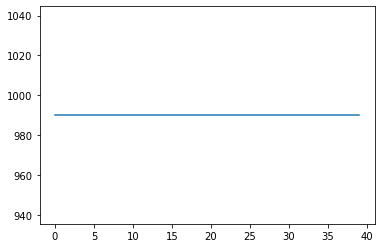

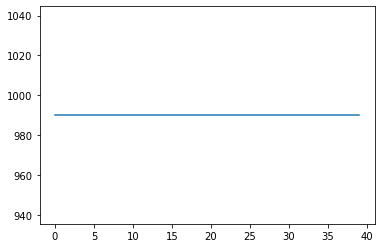

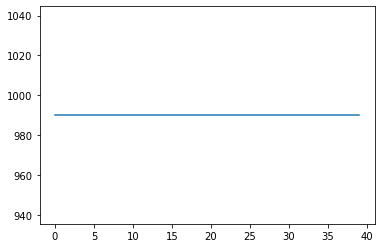

In [24]:
n=10
e=0.1
ts1=np.arange(S1o-2000,S1o+2000,100)
ts2=np.arange(S2o-1000,S2o+1000,50)

for k in range(1,4):
    n1=n**k
    D1=np.zeros(1)
    for i,j in zip(ts1,ts2):
        D1=np.append(D1,W_Auto_Bar(Tr,Cap,C,n1,T,m,sigma1/np.sqrt(3*252),sigma2/np.sqrt(3*252),sigma12,Not,i,j,rf*3,e))
    plt.plot(D1[1:])
    plt.show()

Le Prix est constant donc le $\Delta$ est null.

Ce que nous allons montrer aussi par la Finite Difference Method 

On peut approximer delta par:
$$
  \partial_x P(x,\sigma) \approx \frac{\bar{P}^n(x+\varepsilon,\sigma)-\bar{P}^n(x-\varepsilon,\sigma)}{2\varepsilon},\quad \text{with }\bar{P}^n(x,\sigma) :=  \frac{1}{n} \sum_{k=1}^n  Payoff^{k}_{Disc}{k}
$$
Il s'agit bien d'une variation  de prix  par rapport au spots initials des deux indices $CAC_{t_{0}}$ et $Euro_{t_{0}}$ ce qui est présenté par ce code:

In [25]:

def DeltaFINITE(Tr,Cap,C,n,T,m,sigma1,sigma2,sigma12,Not,S1o,S2o,rf,e):
    ##/(3*252)
    m1=T*252 
    dt=T/m1

    DZ1 = np.sqrt(dt)*np.random.randn(n,m1)
    DZ2 = np.sqrt(dt)*np.random.randn(n,m1)
    DS1 = np.exp((rf-(sigma1**2+sigma12**2)/2)*dt + sigma1*DZ1+sigma12*DZ2)
    DS2 = np.exp((rf-(sigma2**2+sigma12**2)/2)*dt + sigma2*DZ2+sigma12*DZ1)
    
    ######
    
    S1p=(S1o+e)*np.cumprod(DS1,axis=1)
    S1m=(S1o-e)*np.cumprod(DS1,axis=1)
    
    S2p=(S2o+e)*np.cumprod(DS2,axis=1)
    S2m=(S2o-e)*np.cumprod(DS2,axis=1)
    
    S1poCol=np.zeros(n)+(S1o+e)
    S1moCol=np.zeros(n)+(S1o-e)
    
    S2poCol=np.zeros(n)+(S2o+e)
    S2moCol=np.zeros(n)+(S2o-e)
    
    S1p=np.c_[S1poCol,S1p]
    S1m=np.c_[S1moCol,S1m]
    
    
    S2p=np.c_[S2poCol,S2p]
    S2m=np.c_[S2moCol,S2m]

    CACpSim=S1p
    EuropSim=S2p
    CACmSim=S1m
    EuromSim=S2m
        
    #######
    

    ###### p
    
    vectm=np.arange(0,T*252+252/m,252/m) ###
    vectm[1:]=vectm[1:]-1
    
    CACp6m=CACpSim[:,vectm.astype(int)]
    Europ6m=EuropSim[:,vectm.astype(int)] 
    RCACp6m= CACp6m[:,1:]/CACp6m[:,:-1]  #Rapport ti/t(i-1) ######
    REurop6m=Europ6m[:,1:]/Europ6m[:,:-1] 
    matrixMinp=np.minimum(RCACp6m,REurop6m) #Min
    
    RCACpo=CACp6m[:,1:]/(S1o+e)
    REurop0=Europ6m[:,1:]/(S2o+e)
    matrixMinop=np.minimum(RCACpo,REurop0) #Min ti/tO
    matrixlossp=(matrixMinop<=0.5)*1*(matrixMinop-1)
    
    Tr=np.array(Tr)+1
    Cap=np.array(Cap)+1
    C=np.array(C)
    
    indMin0p=(RCACpo>=REurop0)*1#
    indMinp=(RCACp6m>=REurop6m)*1 # 0 SI CAC=MIN 1 SI EURO=MIN, indice des min
    TRp=Tr[indMinp]
    CAPkp=Cap[indMin0p]#
    prp=np.cumsum((matrixMinop>=CAPkp)*1,axis=1)#
    Hk1p=(prp==0)*1 #matrice 0 si maxmin>=Hk
                
    matrixCp=C[indMinp] #matrice coupon
    vectE=np.arange(0,T+1/m,1/m) 
    
    Payoff1p=np.zeros(TRp.shape)
    C1p=(matrixMinp>=TRp)*1
    C2p=(matrixMinop>=CAPkp)*1                                                                                      
    
    H1p=np.zeros(TRp.shape)
    H1p[:,0]=H1p[:,0]+1
    H1p[:,1:]=Hk1p[:,:-1]
    
    vectE1=np.vstack([vectE[1:]]*n) 

    Payoff1p[:,0]=matrixCp[:,0]*Not*(matrixMinp[:,0]>=TRp[:,0])*1+Not*(1+matrixlossp[:,0])*C2p[:,0]
    Payoff1p[:,1:-1]=H1p[:,1:-1]*(matrixCp[:,1:-1]*Not*C1p[:,1:-1]+Not*(1+matrixlossp[:,1:-1])*C2p[:,1:-1])*np.exp(-rf*vectE1[:,0:-2])
    Payoff1cump=np.cumsum(Payoff1p, axis=1)
    Payoff1cump[:,-1]=Payoff1cump[:,-2]+(Not*(1+matrixlossp[:,-1])+(matrixCp[:,-1]*Not*C1p[:,-1]))*(H1p[:,-1])*np.exp(-rf*vectE1[:,-1])
    
    ###### m 
    
    CAC6m=CACmSim[:,vectm.astype(int)]
    Euro6m=EuromSim[:,vectm.astype(int)] 
    RCAC6m= CAC6m[:,1:]/CAC6m[:,:-1]  #Rapport ti/t(i-1) ######
    REuro6m=Euro6m[:,1:]/Euro6m[:,:-1] 
    matrixMin=np.minimum(RCAC6m,REuro6m) #Min

    RCACo=CAC6m[:,1:]/(S1o-e) #########
    REuro0=Euro6m[:,1:]/(S2o-e)
    matrixMino=np.minimum(RCACo,REuro0) #Min ti/tO
    matrixloss=(matrixMino<=0.5)*1*(matrixMino-1)
    
    
    indMin=(RCAC6m>=REuro6m)*1 # 0 SI CAC=MIN 1 SI EURO=MIN, indice des min
    TR=Tr[indMin]
    indMin0=(RCACo>=REuro0)*1#
    CAPk=Cap[indMin0]#
    pr=np.cumsum((matrixMino>=CAPk)*1,axis=1)
    Hk1=(pr==0)*1 #matrice 0 si maxmin>=Hk
                
    matrixC=C[indMin] #matrice coupon
    vectE=np.arange(0,T+1/m,1/m) 
    
    Payoff1=np.zeros(TR.shape)
    C1=(matrixMin>=TR)*1
    C2=(matrixMino>=CAPk)*1                                                                                     
    
    H1=np.zeros(TR.shape)
    H1[:,0]=H1[:,0]+1
    H1[:,1:]=Hk1[:,:-1]
    
    vectE1=np.vstack([vectE[1:]]*n) 

    Payoff1[:,0]=matrixC[:,0]*Not*(matrixMin[:,0]>=TR[:,0])*1+Not*(1+matrixloss[:,0])*C2[:,0]
    Payoff1[:,1:-1]=H1[:,1:-1]*(matrixC[:,1:-1]*Not*C1[:,1:-1]+Not*(1+matrixloss[:,1:-1])*C2[:,1:-1])*np.exp(-rf*vectE1[:,0:-2])
    Payoff1cum=np.cumsum(Payoff1, axis=1)
    Payoff1cum[:,-1]=Payoff1cum[:,-2]+(Not*(1+matrixloss[:,-1])+(matrixC[:,-1]*Not*C1[:,-1]))*(H1[:,-1])*np.exp(-rf*vectE1[:,-1])
    
    E=(Payoff1cump[:,-1]-Payoff1cum[:,-1])/(2*e)
    p=np.mean(E)
    s=np.std(E)

    return(p)
    
    

$~~$

Un petit exemple de tester la fonction DeltaFINITE

In [26]:
e=0.1
n=100
t1=time()
print("Delta=",DeltaFINITE(Tr,Cap,C,n,T,m,sigma1/np.sqrt(3*252),sigma2/np.sqrt(3*252),sigma12,Not,S1o,S2o,rf,e))
t2=time()
print("Le temps d'exécution pour n=",n,"est",t2-t1,"\n")

Delta= 0.0
Le temps d'exécution pour n= 100 est 0.01599287986755371 



Le Delta est null et les  graphes de $\Delta$  pour plusieurs simulations ci-dessous confirment le résultat.

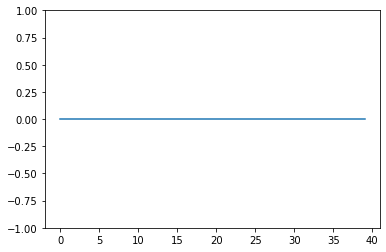

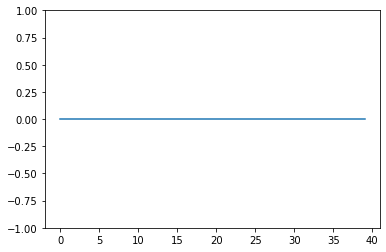

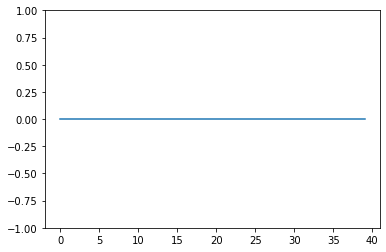

In [29]:
n=10
e=0.1
ts1=np.arange(S1o-2000,S1o+2000,100)
ts2=np.arange(S2o-1000,S2o+1000,50)

for k in range(1,4):
    n1=n**k
    D2=np.zeros(1)
    for i,j in zip(ts1,ts2):
        D2=np.append(D2,DeltaFINITE(Tr,Cap,C,n1,T,m,sigma1/np.sqrt(3*252),sigma2/np.sqrt(3*252),sigma12,Not,i,j,rf*3,e))
    plt.plot(D2[1:])
    plt.ylim(-1,1)
    plt.show()

### 2.Gamma

$\Gamma=\partial_{x x} P(x,\sigma)$


Du fait qu'on a montré que le $\Delta$ était null alors le $\Gamma$ est null aussi.

### 3.Vega

$Vega=\partial_\sigma P(x,\sigma)$

Représentation du Prix en fonction de la volatilité


 Simulation pour n= 1000


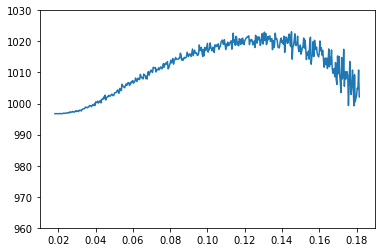

In [77]:
##VEGA
Vs1=np.arange(0.5,5,0.01)
for j in range(1,3):
    v1=np.zeros(1)
    n=10**(j+1)
    print("\n","Simulation pour n=",n)
    for i in Vs1:
        v1=np.append(v1,W_Auto_Bar(Tr,Cap,C,n,T,m,i,i,sigma12,Not,S1o,S2o,rf,"")) #f(S1o)    
    plt.plot(Vs1/np.sqrt(3*252),v1[1:])
    plt.ylim(960,1030)
    plt.show()

On remarque que le Prix augumente légerement  aprés il dimininue.

$$$$

Comme Delta on peut approximer Vega par la méthode de différence finie:
$$
  \partial_\sigma P(x,\sigma) \approx \frac{\bar{P}^n(x,\sigma+\varepsilon)-\bar{P}^n(x,\sigma-\varepsilon)}{2\varepsilon},\quad \text{with }\bar{P}^n(x,\sigma) :=  \frac{1}{n} \sum_{j=1}^n Payoff_{Disc,j}
$$
Il s'agit bien d'une variation  de prix  par rapport au volatilité des deux indices (sigmaS1 et sigmaS2) ce qui est présenté par ce code:


In [45]:
###Vega Finite Difference
n=1000
m1=T*252 
dt=T/m1

DZ1 = np.sqrt(dt)*np.random.randn(n,m1)
DZ2 = np.sqrt(dt)*np.random.randn(n,m1)


def VegaFINITE(Tr,Cap,C,n,T,m,sigma1,sigma2,sigma12,Not,S1o,S2o,rf,e):
    
    ##/(3*252)

    DS1p = np.exp((rf-((sigma1+e)**2+sigma12**2)/2)*dt + (sigma1+e)*DZ1+sigma12*DZ2)
    DS1m = np.exp((rf-((sigma1-e)**2+sigma12**2)/2)*dt + (sigma1-e)*DZ1+sigma12*DZ2)
    DS2p = np.exp((rf-((sigma2+e)**2+sigma12**2)/2)*dt + (sigma2+e)*DZ2+sigma12*DZ1)##
    DS2m = np.exp((rf-((sigma2-e)**2+sigma12**2)/2)*dt + (sigma2-e)*DZ2+sigma12*DZ1)
    
    ######
    
    S1p=S1o*np.cumprod(DS1p,axis=1)
    S1m=S1o*np.cumprod(DS1m,axis=1)
    
    S2p=S2o*np.cumprod(DS2p,axis=1)
    S2m=S2o*np.cumprod(DS2m,axis=1)
    
    S1poCol=np.zeros(n)+(S1o+e)
    S1moCol=np.zeros(n)+(S1o-e)
    
    S2poCol=np.zeros(n)+(S2o+e)
    S2moCol=np.zeros(n)+(S2o-e)
    
    S1p=np.c_[S1poCol,S1p]
    S1m=np.c_[S1moCol,S1m]
    
    
    S2p=np.c_[S2poCol,S2p]
    S2m=np.c_[S2moCol,S2m]

    CACpSim=S1p
    EuropSim=S2p
    CACmSim=S1m
    EuromSim=S2m
        
    #######
    

    ###### p
    
    vectm=np.arange(0,T*252+252/m,252/m) ###
    vectm[1:]=vectm[1:]-1
    
    CACp6m=CACpSim[:,vectm.astype(int)]
    Europ6m=EuropSim[:,vectm.astype(int)] 
    RCACp6m= CACp6m[:,1:]/CACp6m[:,:-1]  #Rapport ti/t(i-1) ######
    REurop6m=Europ6m[:,1:]/Europ6m[:,:-1] 
    matrixMinp=np.minimum(RCACp6m,REurop6m) #Min
    
    RCACpo=CACp6m[:,1:]/S1o
    REurop0=Europ6m[:,1:]/S2o
    matrixMinop=np.minimum(RCACpo,REurop0) #Min ti/tO
    matrixlossp=(matrixMinop<=0.5)*1*(matrixMinop-1)
    
    Tr=np.array(Tr)+1
    Cap=np.array(Cap)+1
    C=np.array(C)

    indMinp=(RCACp6m>=REurop6m)*1 # 0 SI CAC=MIN 1 SI EURO=MIN, indice des min
    TRp=Tr[indMinp]
    
    indMin0p=(RCACpo>=REurop0)*1
    CAPkp=Cap[indMin0p]
    prp=np.cumsum((matrixMinop>=CAPkp)*1,axis=1)
    Hk1p=(prp==0)*1 #matrice 0 si maxmin>=Hk
                
    matrixCp=C[indMinp] #matrice coupon
    vectE=np.arange(0,T+1/m,1/m) 
    
    Payoff1p=np.zeros(TRp.shape)
    C1p=(matrixMinp>=TRp)*1
    C2p=(matrixMinop>=CAPkp)*1                                                                                      
    
    H1p=np.zeros(TRp.shape)
    H1p[:,0]=H1p[:,0]+1
    H1p[:,1:]=Hk1p[:,:-1]
    
    vectE1=np.vstack([vectE[1:]]*n) 

    Payoff1p[:,0]=matrixCp[:,0]*Not*(matrixMinp[:,0]>=TRp[:,0])*1+Not*(1+matrixlossp[:,0])*C2p[:,0]
    Payoff1p[:,1:-1]=H1p[:,1:-1]*(matrixCp[:,1:-1]*Not*C1p[:,1:-1]+Not*(1+matrixlossp[:,1:-1])*C2p[:,1:-1])*np.exp(-rf*vectE1[:,0:-2])
    Payoff1cump=np.cumsum(Payoff1p, axis=1)
    Payoff1cump[:,-1]=Payoff1cump[:,-2]+(Not*(1+matrixlossp[:,-1])+(matrixCp[:,-1]*Not*C1p[:,-1]))*(H1p[:,-1])*np.exp(-rf*vectE1[:,-1])
    
    ###### m 
    
    CAC6m=CACmSim[:,vectm.astype(int)]
    Euro6m=EuromSim[:,vectm.astype(int)] 
    RCAC6m= CAC6m[:,1:]/CAC6m[:,:-1]  #Rapport ti/t(i-1) ######
    REuro6m=Euro6m[:,1:]/Euro6m[:,:-1] 
    matrixMin=np.minimum(RCAC6m,REuro6m) #Min

    RCACo=CAC6m[:,1:]/S1o #########
    REuro0=Euro6m[:,1:]/S2o
    matrixMino=np.minimum(RCACo,REuro0) #Min ti/tO
    matrixloss=(matrixMino<=0.5)*1*(matrixMino-1)
    
    
    indMin=(RCAC6m>=REuro6m)*1 # 0 SI CAC=MIN 1 SI EURO=MIN, indice des min
    TR=Tr[indMin]
    indMin0=(RCACo>=REuro0)*1
    CAPk=Cap[indMin0]
    pr=np.cumsum((matrixMino>=CAPk)*1,axis=1)
    Hk1=(pr==0)*1 #matrice 0 si maxmin>=Hk
                
    matrixC=C[indMin] #matrice coupon
    vectE=np.arange(0,T+1/m,1/m) 
    
    Payoff1=np.zeros(TR.shape)
    C1=(matrixMin>=TR)*1
    C2=(matrixMino>=CAPk)*1                                                                                      
    
    H1=np.zeros(TR.shape)
    H1[:,0]=H1[:,0]+1
    H1[:,1:]=Hk1[:,:-1]
    
    vectE1=np.vstack([vectE[1:]]*n) 

    Payoff1[:,0]=matrixC[:,0]*Not*(matrixMin[:,0]>=TR[:,0])*1+Not*(1+matrixloss[:,0])*C2[:,0]
    Payoff1[:,1:-1]=H1[:,1:-1]*(matrixC[:,1:-1]*Not*C1[:,1:-1]+Not*(1+matrixloss[:,1:-1])*C2[:,1:-1])*np.exp(-rf*vectE1[:,0:-2])
    Payoff1cum=np.cumsum(Payoff1, axis=1)
    Payoff1cum[:,-1]=Payoff1cum[:,-2]+(Not*(1+matrixloss[:,-1])+(matrixC[:,-1]*Not*C1[:,-1]))*(H1[:,-1])*np.exp(-rf*vectE1[:,-1])
    
    E=(Payoff1cump[:,-1]-Payoff1cum[:,-1])/(2*e)
    p=np.mean(E)
    s=np.std(E)

    return(p)
    

$~~$

 Un petit exemple pour tester la fonction VegaFINITE

In [216]:
##TEST

e=0.01
VegaFINITE(Tr,Cap,C,n,T,m,0.05,0.05,sigma12,Not,S1o,S2o,rf,e)


328.18156645384175

Nous avons tracé la courbe de Vega en fonction de volatilities.


 Vega en fonction de vol

 Simulation pour n= 1000


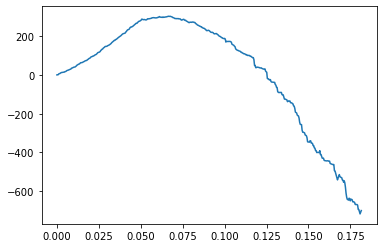

In [80]:

e=0.025
n=1000
vf1=np.zeros(1)
Vf1=np.arange(0,5,0.01)


print("\n","Vega en fonction de vol")
print("\n","Simulation pour n=",n)

for i in Vf1:
    vf1=np.append(vf1,VegaFINITE(Tr,Cap,C,n,T,m,i/np.sqrt(3*252),i/np.sqrt(3*252),sigma12,Not,S1o,S2o,rf,e))     
plt.plot(Vf1/np.sqrt(3*252),vf1[1:])






On remarque que vega augumente jusqu'à qu'elle atteint un maximum aprés elle diminue et elle prend des valeurs négative.

### 4.Vega Convexity
Toujours par la finite difference method on approxime vega convexity

$\partial_{\sigma\sigma} P(x,\sigma) \approx \frac{\bar{P}^{n}(x,\sigma+\varepsilon)+\bar{P}^{n}(x,\sigma+\varepsilon)-2 \bar{P}^{n}(x,\sigma)}{\varepsilon^{2}}$

In [44]:
###Vega Convexity
n=1000
m1=T*252 
dt=T/m1

DZ1 = np.sqrt(dt)*np.random.randn(n,m1)
DZ2 = np.sqrt(dt)*np.random.randn(n,m1)

def VegaConvex(Tr,Cap,C,n,T,m,sigma1,sigma2,sigma12,Not,S1o,S2o,rf,e):
    
   ##/(3*252)


    DS1 = np.exp((rf-(sigma1**2+sigma12**2)/2)*dt + sigma1*DZ1+sigma12*DZ2)
    DS2 = np.exp((rf-(sigma2**2+sigma12**2)/2)*dt + sigma2*DZ2+sigma12*DZ1)
    
    DS1p = np.exp((rf-((sigma1+e)**2+sigma12**2)/2)*dt + (sigma1+e)*DZ1+sigma12*DZ2)
    DS1m = np.exp((rf-((sigma1-e)**2+sigma12**2)/2)*dt + (sigma1-e)*DZ1+sigma12*DZ2)
    DS2p = np.exp((rf-((sigma2+e)**2+sigma12**2)/2)*dt + (sigma2+e)*DZ2+sigma12*DZ1)##
    DS2m = np.exp((rf-((sigma2-e)**2+sigma12**2)/2)*dt + (sigma2-e)*DZ2+sigma12*DZ1)
    
    ######
    
        
    S1=S1o*np.cumprod(DS1,axis=1)
    S2=S2o*np.cumprod(DS2,axis=1)
    S1oCol=np.zeros(n)+(S1o)
    S2oCol=np.zeros(n)+(S2o)
    
    S1=np.c_[S1oCol,S1]
    S2=np.c_[S2oCol,S2]
    
    S1p=S1o*np.cumprod(DS1p,axis=1)
    S1m=S1o*np.cumprod(DS1m,axis=1)
    
    S2p=S2o*np.cumprod(DS2p,axis=1)
    S2m=S2o*np.cumprod(DS2m,axis=1)
    
    S1poCol=np.zeros(n)+(S1o+e)
    S1moCol=np.zeros(n)+(S1o-e)
    
    S2poCol=np.zeros(n)+(S2o+e)
    S2moCol=np.zeros(n)+(S2o-e)
    
    S1p=np.c_[S1poCol,S1p]
    S1m=np.c_[S1moCol,S1m]
    
    
    S2p=np.c_[S2poCol,S2p]
    S2m=np.c_[S2moCol,S2m]

    CACpSim=S1p
    EuropSim=S2p
    CACmSim=S1m
    EuromSim=S2m
        
    CACSim=S1
    EuroSim=S2
    
    #######
    vectm=np.arange(0,T*252+252/m,252/m) ###
    vectm[1:]=vectm[1:]-1
    
    CAC6m=CACSim[:,vectm.astype(int)]
    Euro6m=EuroSim[:,vectm.astype(int)] 
    RCAC6m= CAC6m[:,1:]/CAC6m[:,:-1]  #Rapport ti/t(i-1) ######
    REuro6m=Euro6m[:,1:]/Euro6m[:,:-1] 
    matrixMin=np.minimum(RCAC6m,REuro6m) #Min

    RCACo=CAC6m[:,1:]/S1o #########
    REuro0=Euro6m[:,1:]/S2o
    matrixMino=np.minimum(RCACo,REuro0) #Min ti/tO
    matrixloss=(matrixMino<=0.5)*1*(matrixMino-1)
    
    Tr=np.array(Tr)+1
    Cap=np.array(Cap)+1
    C=np.array(C)
    indMin=(RCAC6m>=REuro6m)*1 # 0 SI CAC=MIN 1 SI EURO=MIN, indice des min
    
    TR=Tr[indMin]
    indMin0=(RCACo>=REuro0)*1
    CAPk=Cap[indMin0]
    pr=np.cumsum((matrixMino>=CAPk)*1,axis=1)
    Hk1=(pr==0)*1 #matrice 0 si maxmin>=Hk
                
    matrixC=C[indMin] #matrice coupon
    vectE=np.arange(0,T+1/m,1/m) 
    
    Payoff1=np.zeros(TR.shape)
    C1=(matrixMin>=TR)*1
    C2=(matrixMino>=CAPk)*1                                                                                      
    
    H1=np.zeros(TR.shape)
    H1[:,0]=H1[:,0]+1
    H1[:,1:]=Hk1[:,:-1]
    
    vectE1=np.vstack([vectE[1:]]*n) 

    Payoff1[:,0]=matrixC[:,0]*Not*(matrixMin[:,0]>=TR[:,0])*1+Not*(1+matrixloss[:,0])*C2[:,0]
    Payoff1[:,1:-1]=H1[:,1:-1]*(matrixC[:,1:-1]*Not*C1[:,1:-1]+Not*(1+matrixloss[:,1:-1])*C2[:,1:-1])*np.exp(-rf*vectE1[:,0:-2])
    Payoff1cum=np.cumsum(Payoff1, axis=1)
    Payoff1cum[:,-1]=Payoff1cum[:,-2]+(Not*(1+matrixloss[:,-1])+(matrixC[:,-1]*Not*C1[:,-1]))*(H1[:,-1])*np.exp(-rf*vectE1[:,-1])
    
    ###### p
    

    
    CACp6m=CACpSim[:,vectm.astype(int)]
    Europ6m=EuropSim[:,vectm.astype(int)] 
    RCACp6m= CACp6m[:,1:]/CACp6m[:,:-1]  #Rapport ti/t(i-1) ######
    REurop6m=Europ6m[:,1:]/Europ6m[:,:-1] 
    matrixMinp=np.minimum(RCACp6m,REurop6m) #Min
    
    RCACpo=CACp6m[:,1:]/S1o
    REurop0=Europ6m[:,1:]/S2o
    matrixMinop=np.minimum(RCACpo,REurop0) #Min ti/tO
    matrixlossp=(matrixMinop<=0.5)*1*(matrixMinop-1)

    indMinp=(RCACp6m>=REurop6m)*1 # 0 SI CAC=MIN 1 SI EURO=MIN, indice des min
    TRp=Tr[indMinp]
    indMin0p=(RCACpo>=REurop0)*1
    CAPkp=Cap[indMin0p]
    prp=np.cumsum((matrixMinop>=CAPkp)*1,axis=1)
    Hk1p=(prp==0)*1 #matrice 0 si maxmin>=Hk
                
    matrixCp=C[indMinp] #matrice coupon
    vectE=np.arange(0,T+1/m,1/m) 
    
    Payoff1p=np.zeros(TRp.shape)
    C1p=(matrixMinp>=TRp)*1
    C2p=(matrixMinop>=CAPkp)*1                                                                                      
    
    H1p=np.zeros(TRp.shape)
    H1p[:,0]=H1p[:,0]+1
    H1p[:,1:]=Hk1p[:,:-1]

    Payoff1p[:,0]=matrixCp[:,0]*Not*(matrixMinp[:,0]>=TRp[:,0])*1+Not*(1+matrixlossp[:,0])*C2p[:,0]
    Payoff1p[:,1:-1]=H1p[:,1:-1]*(matrixCp[:,1:-1]*Not*C1p[:,1:-1]+Not*(1+matrixlossp[:,1:-1])*C2p[:,1:-1])*np.exp(-rf*vectE1[:,0:-2])
    Payoff1cump=np.cumsum(Payoff1p, axis=1)
    Payoff1cump[:,-1]=Payoff1cump[:,-2]+(Not*(1+matrixlossp[:,-1])+(matrixCp[:,-1]*Not*C1p[:,-1]))*(H1p[:,-1])*np.exp(-rf*vectE1[:,-1])
    
    ###### m 
    
    CACm6m=CACmSim[:,vectm.astype(int)]
    Eurom6m=EuromSim[:,vectm.astype(int)] 
    RCACm6m= CACm6m[:,1:]/CACm6m[:,:-1]  #Rapport ti/t(i-1) ######
    REurom6m=Eurom6m[:,1:]/Eurom6m[:,:-1] 
    matrixMinm=np.minimum(RCACm6m,REurom6m) #Min

    RCACmo=CACm6m[:,1:]/S1o #########
    REurom0=Eurom6m[:,1:]/S2o
    matrixMinom=np.minimum(RCACmo,REurom0) #Min ti/tO
    matrixlossm=(matrixMinom<=0.5)*1*(matrixMinom-1)
    
    ############
    
    indMinm=(RCACm6m>=REurom6m)*1 # 0 SI CAC=MIN 1 SI EURO=MIN, indice des min
    TRm=Tr[indMinm]
    indMin0m=(RCACmo>=REurom0)*1
    CAPkm=Cap[indMinm]
    prm=np.cumsum((matrixMinom>=CAPkm)*1,axis=1)
    Hk1m=(prm==0)*1 #matrice 0 si maxmin>=Hk
                
    matrixCm=C[indMinm] #matrice coupon
    
    Payoff1m=np.zeros(TRm.shape)
    C1m=(matrixMinm>=TRm)*1
    C2m=(matrixMinom>=CAPkm)*1                                                                                      
    
    H1m=np.zeros(TRm.shape)
    H1m[:,0]=H1m[:,0]+1
    H1m[:,1:]=Hk1m[:,:-1]

    Payoff1m[:,0]=matrixCm[:,0]*Not*(matrixMinm[:,0]>=TRm[:,0])*1+Not*(1+matrixlossm[:,0])*C2m[:,0]
    Payoff1m[:,1:-1]=H1m[:,1:-1]*(matrixCm[:,1:-1]*Not*C1m[:,1:-1]+Not*(1+matrixlossm[:,1:-1])*C2m[:,1:-1])*np.exp(-rf*vectE1[:,0:-2])
    Payoff1cumm=np.cumsum(Payoff1m, axis=1)
    Payoff1cumm[:,-1]=Payoff1cumm[:,-2]+(Not*(1+matrixlossm[:,-1])+(matrixCm[:,-1]*Not*C1m[:,-1]))*(H1m[:,-1])*np.exp(-rf*vectE1[:,-1])
    
    E=(Payoff1cump[:,-1]+Payoff1cumm[:,-1]-2*Payoff1cum[:,-1])/(e**2)
    p=np.mean(E)
    s=np.std(E)

    return(p)
    



    

Nous avons tracé la courbe de vega convexity en fonction de volatilités.

#### Noté Bien pour $n=1000$ ce code prend une minute pour etre exécuter.


 Vega convexity en fonction de vol

 Simulation pour n= 1000
Le temps d'exécution est= 72.4070520401001


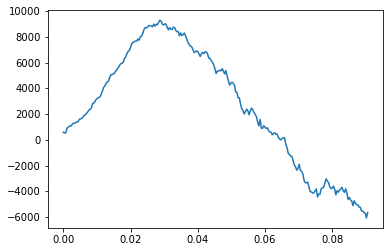

In [78]:
t1=time()
e=0.025
vf1=np.zeros(1)
Vf1=np.arange(0,2.5,0.01)


print("\n","Vega convexity en fonction de vol")
print("\n","Simulation pour n=",n)

for i in Vf1:
    vf1=np.append(vf1,VegaConvex(Tr,Cap,C,n,T,m,i/np.sqrt(3*252),i/np.sqrt(3*252),sigma12,Not,S1o,S2o,rf,e))     
plt.plot(Vf1/np.sqrt(3*252),vf1[1:])
t2=time()
print("Le temps d'exécution est=",t2-t1)

### 5.Vega Skew
$\partial_x Vega=\partial_{x \sigma} P(x,\sigma)$

On trace la courbe de Vega en fonction de spots initials $CAC_{t_{0}}$ et $Euro_{t_{0}}$

vega en fonction de spots
Le temps d'exécution est= 9.35090184211731


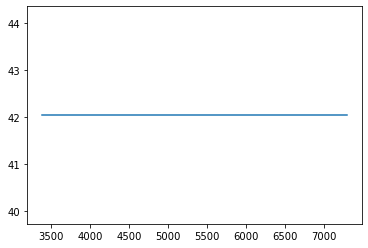

In [81]:
t1=time()
e=0.01
n=1000
ts1=np.arange(S1o-2000,S1o+2000,100)
ts2=np.arange(S2o-1000,S2o+1000,50)
m1=T*252 
dt=T/m1
print("vega en fonction de spots")
DZ1 = np.sqrt(dt)*np.random.randn(n,m1)
DZ2 = np.sqrt(dt)*np.random.randn(n,m1)
D1=np.zeros(1)
for i,j in zip(ts1,ts1):
    D1=np.append(D1,VegaFINITE(Tr,Cap,C,n,T,m,sigma1/np.sqrt(3*252),sigma2/np.sqrt(3*252),sigma12,Not,i,j,rf*3,e))
plt.plot(ts1,D1[1:])
t2=time()
print("Le temps d'exécution est=",t2-t1)

Vega en fonction de spots est une constante donc on s'attendre a une vega skew null.

On peut approximer vega skew en appliquant la finite difffrence méthode à vega:

$$
  \partial_x vega(x,\sigma) \approx \frac{\bar{vega}^n(x+\varepsilon,\sigma)-\bar{vega}^n(x-\varepsilon,\sigma)}{2\varepsilon}
$$
Ce qui est présenté par ce code:




In [46]:
m1=T*252 
dt=T/m1

DZ1 = np.sqrt(dt)*np.random.randn(n,m1)
DZ2 = np.sqrt(dt)*np.random.randn(n,m1)

def VegaSkew(Tr,Cap,C,n,T,m,sigma1,sigma2,sigma12,Not,S1o,S2o,rf,e):
    up=VegaFINITE(Tr,Cap,C,n,T,m,sigma1,sigma2,sigma12,Not,S1o+e,S2o+e,rf,e*0.1)
    um=VegaFINITE(Tr,Cap,C,n,T,m,sigma1,sigma2,sigma12,Not,S1o-e,S2o-e,rf,e*0.1)
    E=(up-um)/(2*e)
    return(E)    

Ensuite on trace la courbe de vega skew en fonction de spots initials

courbe de vega skew en fonction de spots
temps d'exécution pour n= 1000 est 15.850240230560303


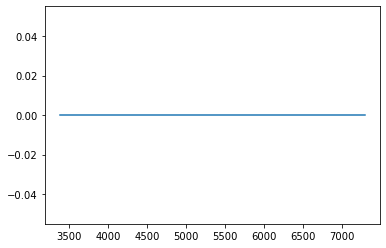

In [82]:
t1=time()
e=0.1
n=1000
ts1=np.arange(S1o-2000,S1o+2000,100)
ts2=np.arange(S2o-1000,S2o+1000,50)
m1=T*252 
dt=T/m1

DZ1 = np.sqrt(dt)*np.random.randn(n,m1)
DZ2 = np.sqrt(dt)*np.random.randn(n,m1)
D1=np.zeros(1)
print("courbe de vega skew en fonction de spots")
for i,j in zip(ts1,ts1):
    D1=np.append(D1,VegaSkew(Tr,Cap,C,n,T,m,sigma1/np.sqrt(3*252),sigma2/np.sqrt(3*252),sigma12,Not,i,j,rf*3,e))
plt.plot(ts1,D1[1:])
#plt.ylim(-1,1)
t2=time()
print("temps d'exécution pour n=",n,"est",t2-t1)

$~~$

##### Courbe de Prix de produit en fonction de Treshold 

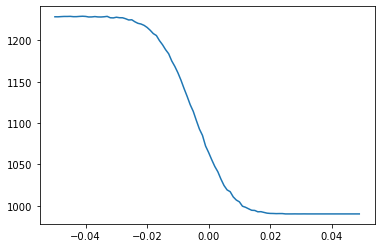

In [75]:
n=1000
ts2=np.arange(-0.05,0.05,0.001)


D2=np.zeros(1)
for i,j in zip(ts2,ts2):
    D2=np.append(D2,W_Auto_Bar([i,i],Cap,C,n,T,m,sigma1,sigma2,sigma12,Not,S1o,S2o,rf*3,""))
plt.plot(ts2,D2[1:])
plt.show()

$~~$

#### Courbe de Prix de produit en fonction de Barrières

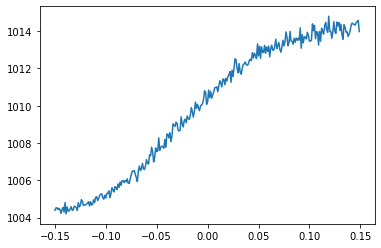

In [74]:
n=10000
ts1=np.arange(-0.15,0.15,0.001)


D1=np.zeros(1)
for i,j in zip(ts1,ts1):
    D1=np.append(D1,W_Auto_Bar(Tr,[i,i],C,n,T,m,3,3,sigma12,Not,S1o,S2o,rf*3,""))
plt.plot(ts1,D1[1:])

plt.show()